# Single-Order Spectrum

This will show how to fit a single-order spectrum using the setup file. 

<div class="alert alert-info">
    
**Note:** This documentation is not meant to be an exhaustive tour of *Starfish*'s features, but rather a simple example showing a workflow typical of fitting data.

</div>

## Preprocessing

Normally, you would pre-process your data. This includes loading the fits files, separating out the wavelengths, fluxes, uncertainties, and any masks. In addition, you would need to convert your data into the same units as your emulator. For this example, though, I've already created a spectrum that you can load directly.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use("seaborn")

/tmp/ipykernel_133165/1026186543.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


<AxesSubplot: xlabel='$\\lambda$ [$\\AA$]', ylabel='$f_\\lambda$ [$erg/cm^2/s/cm$]'>

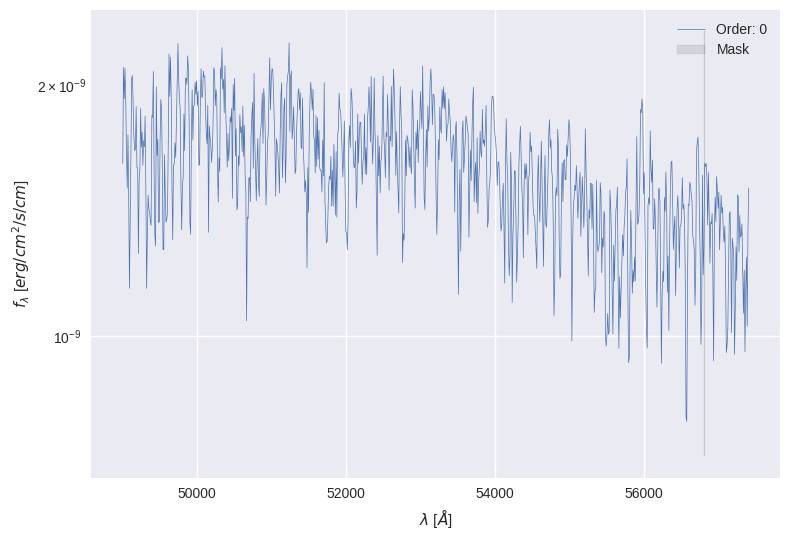

In [2]:
from Starfish.spectrum import Spectrum
from Starfish.conversions import *
data = Spectrum.load("JWST/VHS1256b_V2_accepted.txt", comment="#", names = ["waves", "fluxes", "sigmas", "instrument"], spectrum_filter = lambda df: df[df['instrument'] == 'MIRI MRS 1A'], convert = [microns_to_angstrom, w_m2_microns_to_erg_cm2_s_cm])

data.plot()

## Setting up the model

Now we can set up our initial model. We need, at minimum, an emulator, our data, and a set of the library grid parameters. Every extra keyword argument we add is added to our list of parameters. For more information on what parameters are available and what effect they have, see the [SpectrumModel documentation](../api/models.rst#SpectrumModel).

Some of these parameters are based on guesses or pre-existing knowledge. In particular, if you want to fit `log_scale`, you should spend some time tuning it by eye, first. We also want our `global_cov:log_amp` to be reasonable, so pay attention to the $\sigma$-contours in the residuals plots, too.

There aren't any previous in-depth works on this star, so we will start with some values based on the spectral type alone.

In [3]:
from Starfish.models import SpectrumModel

model = SpectrumModel(
    "JWST_emu_MIRI_MRS_1A.hdf5",
    data,
    grid_params=[2000, 4.2, 0],
    Av=0,
    global_cov=dict(log_amp=-11, log_ls=4),
)
model

SpectrumModel
-------------
Data: None
Emulator: JWST_emu_MIRI_MRS_1A
Log Likelihood: None

Parameters
  global_cov:
    log_ls: 4.0
    log_amp: -11.0
  Av: 0.0
  T: 2000.0
  logg: 4.2
  log_scale: -20.26811964337941 (fit)

In this plot, we can see the data and model in the left pane, the absolute errors (residuals) along with the diagonal of the covariance matrix as $\sigma$ contours in the top-right, and the relative errors (residuals / flux) in the bottom-right

[<AxesSubplot: xlabel='$\\lambda$ [$\\AA$]', ylabel='$f_\\lambda$ [$erg/cm^2/s/cm$]'>,
 <AxesSubplot: ylabel='$\\Delta f_\\lambda$'>,
 <AxesSubplot: xlabel='$\\lambda$ [$\\AA$]', ylabel='$\\Delta f_\\lambda / f_\\lambda$'>]

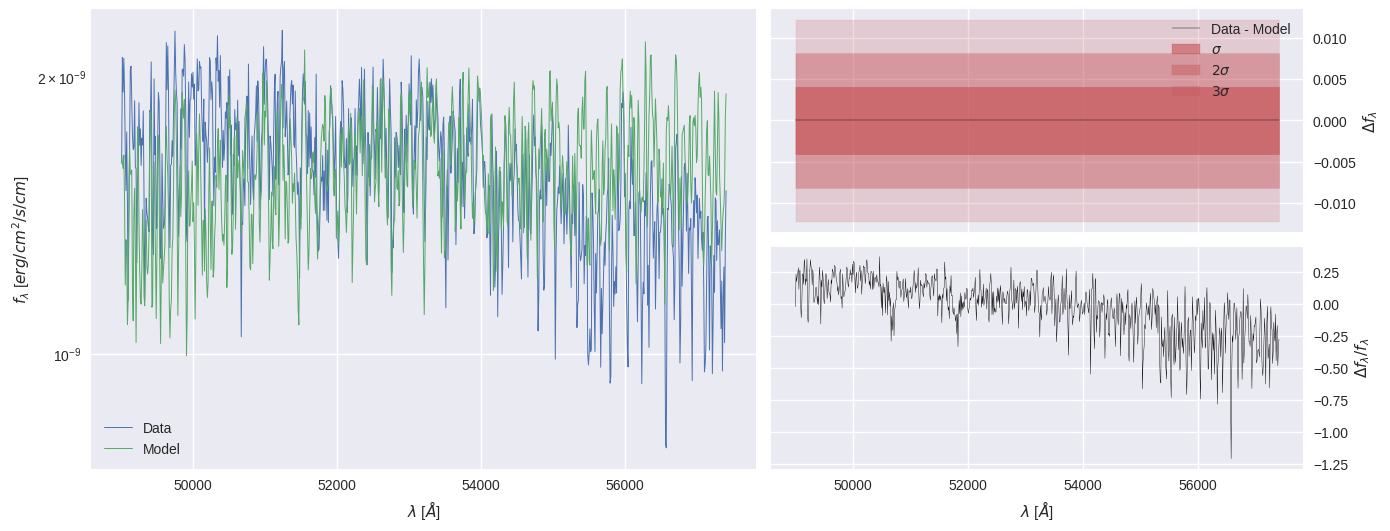

In [4]:
model.plot()

In [5]:
# likelihoods = []
# x = []
# for log_amp in range(-15, 15, 1):
#     if log_amp != 0:
#         model['global_cov:log_amp'] = log_amp
#         likelihoods.append(model.log_likelihood().item())
#         x.append(log_amp)

In [6]:
# import matplotlib.pyplot as plt
# plt.plot(x, likelihoods)

## Numerical Optimization

Now lets do a *maximum a posteriori* (MAP) point estimate for our data. 


Here we freeze `logg` here because the PHOENIX models' response to `logg` compared to our data are relatively flat, so we fix the value using the [freeze](../api/models.rst#parametrization) mechanics. This is equivalent to applying a $\delta$-function prior.

In [7]:
# model.freeze("logg")
# model.freeze("global_cov")
model.labels  # These are the fittable parameters

['global_cov:log_ls', 'global_cov:log_amp', 'Av', 'T', 'logg']

In [8]:
from Starfish.scalers import *
model.params.apply_scaler("T", MinMaxScaler(200, 2400))
model.params.apply_scaler("logg", MinMaxScaler(2, 5))
# model.params.apply_scaler("T", NormalScaler(6800, 100))
# model.params.apply_scaler("MH", MinMaxScaler(-0.5, 0.5))
model.params.apply_scaler("Av", HalfNormalScaler(0, 5))
model.params.apply_scaler("global_cov:log_amp", NormalScaler(-20, 20))
model.params.apply_scaler("global_cov:log_ls", NormalScaler(10, 50))


Here we specify some priors using `scipy.stats` classes. If you have a custom distribution you want to use, create a class and make sure it has a `logpdf` member function.

In [41]:
from Starfish.distributions import *
device = 'cpu'

# priors = {
#     "T": Normal(1200, 100, device= device),
#     "logg": Uniform(2, 5, device = device)
#     # "MH": 0
#     # "logg": Uniform(3, 5, device = device)
# }
priors = { 
    "T": Normal(1200, 100, device= device),
    "logg": Uniform(2, 5, device = device),
    "Av": HalfNormal(5, device = device),
    "global_cov:log_amp": Normal(-20, 20, device = device),
    "global_cov:log_ls": Uniform(0, 50, device = device),
}

In [10]:
import logging
logging.basicConfig(level=logging.INFO)

Using the above priors, we can do our MAP optimization using pytorch Optimizers (ADAM optimizer), which is usefully baked into the `train` method of our model. This should give us a good starting point for our MCMC sampling later. 

In [11]:
model.to(device)

In [12]:
%time model.train(priors, log_interval=100, lr = 0.1, checkpoint_interval=10, checkpoint_path = "model_checkpoints", best_eps=1e-4, )

INFO:SpectrumModel:step: 0 loss: -5540.170313121861 (best loss: -5540.170313121861 @ step: 0)
INFO:SpectrumModel:step: 100 loss: -9639.07194686878 (best loss: -9639.07194686878 @ step: 100)
INFO:SpectrumModel:step: 200 loss: -9640.392054840764 (best loss: -9640.392054840764 @ step: 200)
INFO:SpectrumModel:step: 300 loss: -9641.032835250899 (best loss: -9641.032835250899 @ step: 300)
INFO:SpectrumModel:step: 400 loss: -9641.138697637862 (best loss: -9641.138697637862 @ step: 400)
INFO:SpectrumModel:step: 500 loss: -9641.16891048635 (best loss: -9641.16891048635 @ step: 500)
INFO:SpectrumModel:step: 600 loss: -9641.182239714224 (best loss: -9641.18214479998 @ step: 599)
INFO:SpectrumModel:step: 700 loss: -9641.189522161232 (best loss: -9641.189466197065 @ step: 699)
INFO:SpectrumModel:step: 800 loss: -9641.19402631027 (best loss: -9641.193953539308 @ step: 798)
INFO:SpectrumModel:step: 900 loss: -9641.19704668448 (best loss: -9641.19699626869 @ step: 898)
INFO:SpectrumModel:step: 1000 lo

CPU times: user 39min 17s, sys: 2min 40s, total: 41min 58s
Wall time: 3min 41s


SpectrumModel
-------------
Data: None
Emulator: JWST_emu_MIRI_MRS_1A
Log Likelihood: 9647.827611363922

Parameters
  global_cov:
    log_ls: 36.90391569049187
    log_amp: -34.57430720780525
  Av: 6.914315118833039
  T: 1200.0000013488782
  logg: 3.0
  log_scale: -20.093349407535392 (fit)

[<AxesSubplot: xlabel='$\\lambda$ [$\\AA$]', ylabel='$f_\\lambda$ [$erg/cm^2/s/cm$]'>,
 <AxesSubplot: ylabel='$\\Delta f_\\lambda$'>,
 <AxesSubplot: xlabel='$\\lambda$ [$\\AA$]', ylabel='$\\Delta f_\\lambda / f_\\lambda$'>]

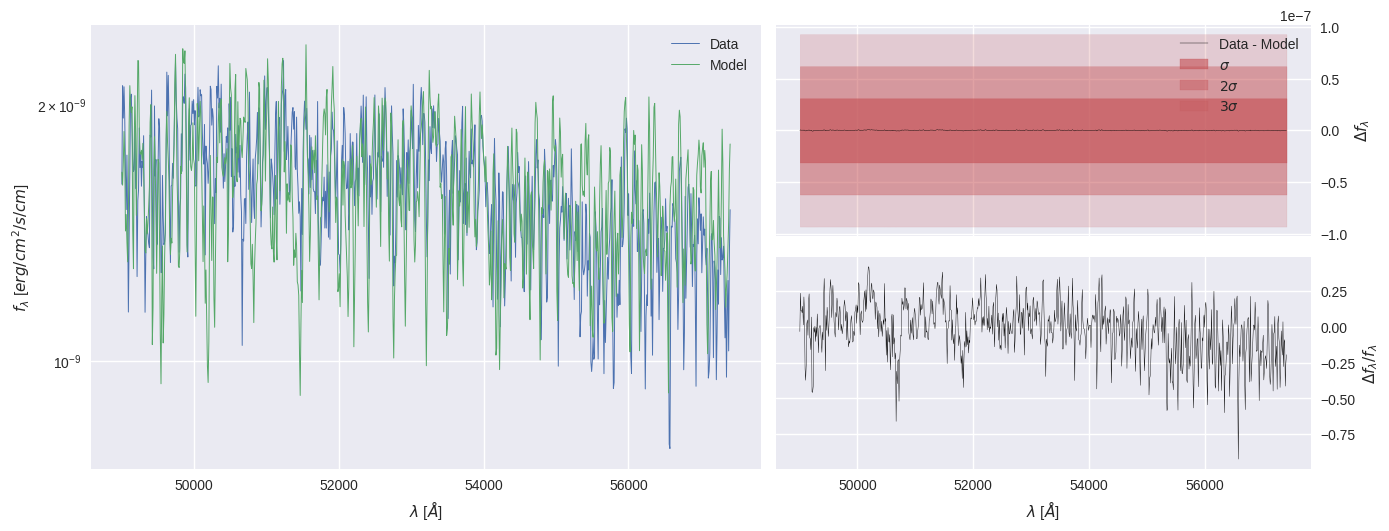

In [13]:
model.to('cpu')
model.plot()

In [14]:
model.save("example_JWST_MAP.toml")

INFO:SpectrumModel:Saved current state at example_JWST_MAP.toml


## MCMC Sampling

Now, we will sample from our model. Note the flexibility we provide with *Starfish* in order to allow sampler front-end that allows blackbox likelihood methods. In our case, we will continue with [emcee](https://github.com/dfm/emcee), which provides an ensemble sampler. We are using pre-release of version `3.0`. This document serves only as an example, and details about emcee's usage should be sought after in its [documentation](https://emcee.readthedocs.io/en/latest/).

For this basic example, I will freeze both the global and local covariance parameters, so we are only sampling over `T`, and `Av`.

In [11]:
import emcee

emcee.__version__

'3.1.3'

In [42]:
model.load("example_JWST_MAP.toml")
model.freeze("global_cov")
model.freeze("logg")
model.clip = False
model.labels

['T', 'Av']

In [43]:
model.params.remove_scaler("T")
model.params.remove_scaler("Av")
# model.params.remove_scaler("MH")
model.params.remove_scaler("logg")

In [44]:
import numpy as np

# Set our walkers and dimensionality
nwalkers = 50
ndim = len(model.labels)

# Initialize gaussian ball for starting point of walkers
scales = {"T": 1, "Av": 0.01}

ball = np.random.randn(nwalkers, ndim)

for i, key in enumerate(model.labels):
    ball[:, i] *= scales[key]
    ball[:, i] += model[key].item()

In [45]:
model.params.items()

[('logg', tensor([3.], dtype=torch.float64)),
 ('T', tensor([1200.0000], dtype=torch.float64)),
 ('Av', tensor([6.9143], dtype=torch.float64)),
 ('global_cov:log_amp', tensor([-34.5743], dtype=torch.float64)),
 ('global_cov:log_ls', tensor([36.9039], dtype=torch.float64))]

In [46]:
model.to('cpu')

In [47]:
# our objective to maximize
def log_prob(P, priors):
    try:
        for lab, val in zip(model.labels, P):
            model[lab] = val
        result = model.log_likelihood(priors)
        return result if isinstance(result, float) else result.item()
    except torch.linalg.LinAlgError as e:
        return -np.inf
    except ValueError as e:
        return -np.inf


# Set up our backend and sampler
backend = emcee.backends.HDFBackend("example_chain.hdf5")
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=(priors,), backend=backend
)

here we start our sampler, and following [this example](https://emcee.readthedocs.io/en/latest/tutorials/monitor/#saving-monitoring-progress) we check every 10 steps for convergence, with a max burn-in of 1000 samples.

<div class="alert alert-warning">

**Warning:** This process *can* take a long time to finish. In cases with high resolution spectra or fully evaluating each nuisance covariance parameter, we recommend running on a remote machine. A setup I recommend is a remote jupyter server, so you don't have to create any scripts and can keeping working in notebooks.

</div>

In [48]:
max_n = 1000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf


# Now we'll sample for up to max_n steps
for sample in sampler.sample(ball, iterations=max_n, progress=True):
    # Only check convergence every 10 steps
    if sampler.iteration % 10:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1
    # skip math if it's just going to yell at us
    if np.isnan(tau).any() or (tau == 0).any():
        continue
    # Check convergence
    converged = np.all(tau * 10 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        print(f"Converged at sample {sampler.iteration}")
        break
    old_tau = tau

 31%|███       | 310/1000 [25:35<56:56,  4.95s/it]  

Converged at sample 310


After our model has converged, let's take a few extra samples to make sure we have clean chains. Remember, we have 50 walkers, so 100 samples ends up becoming 5000 across each chain!

In [49]:
sampler.run_mcmc(backend.get_last_sample(), 100, progress=True)

100%|██████████| 100/100 [08:15<00:00,  4.95s/it]


State([[1.17653898e+03 5.90893002e-01]
 [1.16139004e+03 5.03583813e+00]
 [1.05765952e+03 1.25609385e+00]
 [1.28445277e+03 1.55151766e+00]
 [1.07378378e+03 5.11183352e+00]
 [1.19728550e+03 4.06253133e+00]
 [1.38993571e+03 1.59949105e+00]
 [9.50194293e+02 4.31288314e+00]
 [1.28085217e+03 8.97080692e+00]
 [1.14994200e+03 2.41009359e+00]
 [1.26099875e+03 4.41733943e+00]
 [1.44525427e+03 3.63506984e+00]
 [1.22035957e+03 3.93434058e+00]
 [1.10276897e+03 5.57407987e+00]
 [1.24912577e+03 1.71545549e+00]
 [1.18582470e+03 8.85039035e-01]
 [1.18414383e+03 2.75087026e+00]
 [1.23221845e+03 2.54787409e+00]
 [1.21586921e+03 6.94288543e+00]
 [1.18019111e+03 2.84826178e+00]
 [1.09968097e+03 7.58485365e+00]
 [1.01049696e+03 4.72812717e-01]
 [1.09643237e+03 4.21225966e+00]
 [1.33903138e+03 7.26260128e+00]
 [1.14508144e+03 6.25792589e+00]
 [1.12454998e+03 2.25712903e+00]
 [1.21782840e+03 1.43067077e-01]
 [1.20115326e+03 4.35990376e+00]
 [1.10780460e+03 1.24598695e+01]
 [1.07039763e+03 6.50792499e+00]
 [1.

## MCMC Chain Analysis

Chain analysis is a very broad topic that is mostly out of the scope of this example. 
For our analysis, we like using [ArviZ](https://github.com/arviz-devs/arviz) with a simple [corner](https://github.com/dfm/corner.py) plot as well. 

In [50]:
import arviz as az
import corner

print(az.__version__, corner.__version__)

0.14.0 2.2.1


In [51]:
reader = emcee.backends.HDFBackend("example_chain.hdf5")
full_data = az.from_emcee(reader, var_names=model.labels)

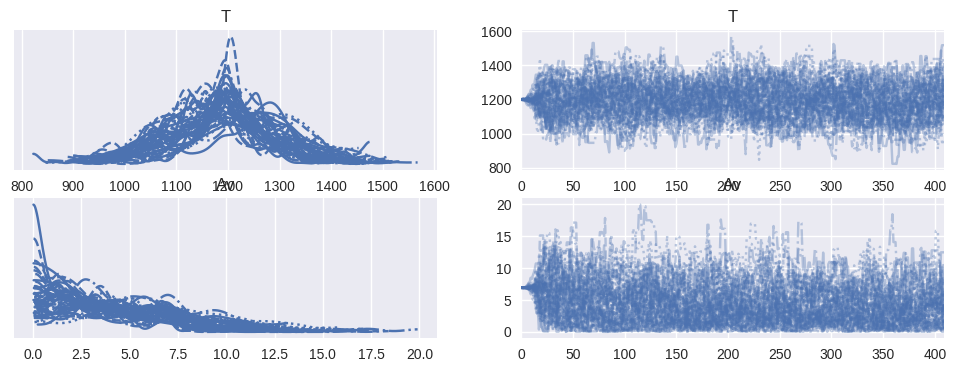

In [52]:
az.plot_trace(full_data);

After seeing our full traces, let's discard and thin some of the burn-in

In [53]:
tau = reader.get_autocorr_time(tol=0)
burnin = int(tau.max())
thin = int(0.3 * np.min(tau))
burn_samples = reader.get_chain(discard=burnin, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, thin=thin)

dd = dict(zip(model.labels, burn_samples.T))
burn_data = az.from_dict(dd)

array([[<AxesSubplot: title={'center': 'T'}>,
        <AxesSubplot: title={'center': 'T'}>],
       [<AxesSubplot: title={'center': 'Av'}>,
        <AxesSubplot: title={'center': 'Av'}>]], dtype=object)

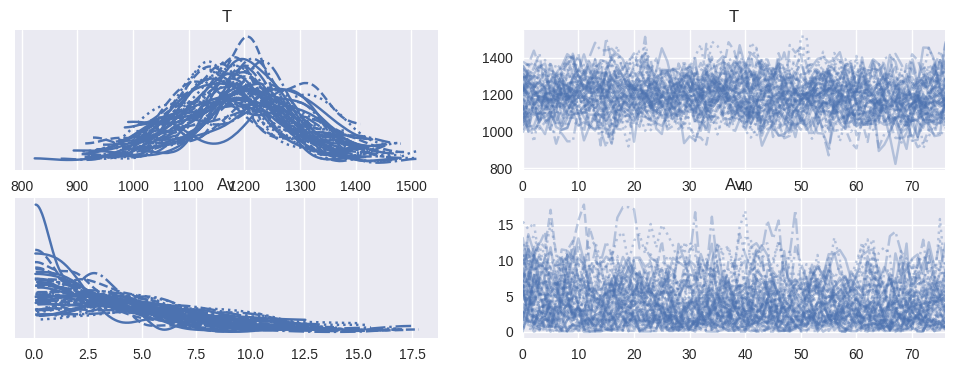

In [54]:
az.plot_trace(burn_data)

In [55]:
az.summary(burn_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
T,1190.510,99.919,1005.671,1380.681,4.975,3.520,404.0,1554.0,1.09
Av,4.137,3.127,0.002,9.913,0.188,0.133,312.0,763.0,1.11


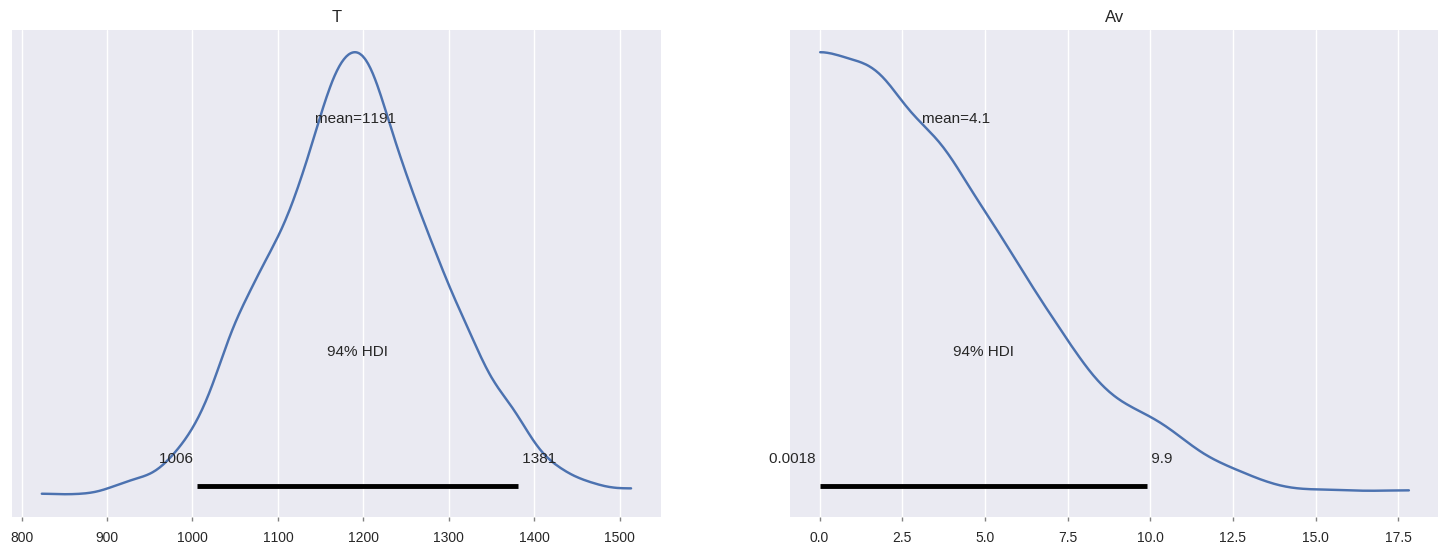

In [56]:
az.plot_posterior(burn_data, ["T", "Av"]);

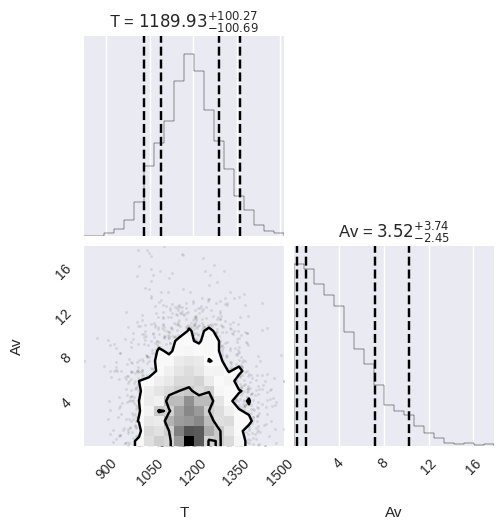

In [57]:
# See https://corner.readthedocs.io/en/latest/pages/sigmas.html#a-note-about-sigmas
sigmas = ((1 - np.exp(-0.5)), (1 - np.exp(-2)))
corner.corner(
    burn_samples.reshape((-1, 2)),
    labels=model.labels,
    quantiles=(0.05, 0.16, 0.84, 0.95),
    levels=sigmas,
    show_titles=True,
);

After looking at our posteriors, let's look at our fit

In [58]:
best_fit = dict(az.summary(burn_data)["mean"])
best_fit
# model.set_param_dict(best_fit)
for k, val in best_fit.items():
    model.params[k] = val
model

SpectrumModel
-------------
Data: None
Emulator: JWST_emu_MIRI_MRS_1A
Log Likelihood: 9647.827511830494

Parameters
  T: 1190.51
  Av: 4.137
  log_scale: -20.16339138712189 (fit)

Frozen Parameters
  logg: 3.0
  global_cov:log_amp: -34.57430720780525
  global_cov:log_ls: 36.90391569049187

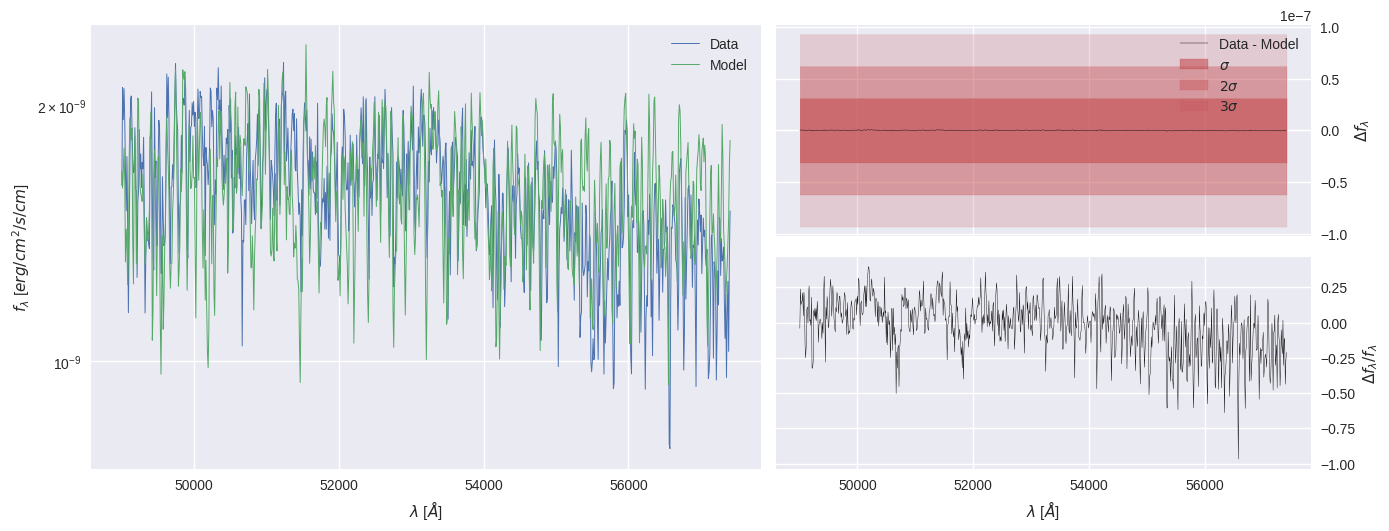

In [59]:
model.plot();

and finally, we can save our best fit.

In [60]:
model.save("example_sampled.toml")

INFO:SpectrumModel:Saved current state at example_sampled.toml


Now, on to the next star!